In [1]:
import sys
sys.path.append("../modules")
import PBD_analog

import numpy as np
import matplotlib.pyplot as plt
plt.style.use("customstyle")
import pandas as pd
import matplotlib

from tqdm.notebook import tqdm
import glob

colors = ["#FFCE00","#0064B0","#9F9825","#98D4E2","#C04191","#F28E42","#83C491","#F3A4BA","#83C491","#CEADD2","#D5C900","#E3B32A","#8D5E2A","#00814F","#98D4E2","#662483","#B90845","#F3A4BA","#D5C900","#00A88F"] 
ncolors = len(colors)

In [2]:
par_names = ["$\\lambda_{}$".format(i) for i in (1,2,3)] + ["$\\mu_{}$".format(i) for i in (1,2)]

# Param values 
par_vals = np.zeros((5, 5, 5))

# default 0.5, 1.0, 0.4, 0.2, 0.2
default = (0.5,1.0,0.4,0.2,0.2)
for i in range(5):
    par_vals[:,:,i] = default[i]

# set values 
factor = [(10**-1, 10**-0.5, 1.0, 10**0.2, 10**0.4), 
        np.geomspace(0.1,10.0,5),
        (10**-1, 10**-0.5, 1.0, 10**0.2, 10**0.4),
        np.geomspace(0.1,10.0,5),
        np.geomspace(0.1,10.0,5)]

for i_par in range(5):
    for i_val in range(5):
        par_vals[i_par, i_val, i_par] = factor[i_par][i_val] * default[i_par]

DR_quantiles_PBD = np.zeros((5,5,5)) 
DR_med_quant_PBD = np.zeros((5,5,5)) 
equiv_rates = np.zeros((5,5,2))

In [3]:
n_par = 5
n_val = 5
n_rep = 500

n_trees_PBD = np.zeros((n_par, n_val), dtype = int)

pbar = tqdm(total = n_par * n_val)

for i_par in range(1, 1+n_par):
    for i_val in range(1, 1+n_val):
        DR = []
        # Load DR statistics for each rep
        for i_rep in range(n_rep):
            dr_df = pd.read_csv("../simulations_output/1-PBD/trees/DR/stree_random-par{}-var{}-rep{}.nwk.csv".format(i_par, i_val, i_rep))
            dr_array = np.array(dr_df.x)
            DR.append(dr_array)

            if len(dr_array) >= 2:
                n_trees_PBD[i_par-1, i_val-1] += 1

        l, m = PBD_analog.analog_BD_rates(*par_vals[i_par-1, i_val-1, :])
        equiv_rates[i_par-1, i_val-1, :] = l,m
        fig, ax = plt.subplots()


        lowest, highest = np.inf, -np.inf
        means = np.zeros(n_rep)
        medians = np.zeros(n_rep)
        up_bar = np.zeros(n_rep)
        low_bar = np.zeros(n_rep)
        for i in range(n_rep):
            quart = np.quantile(DR[i], [0.0, 0.25,0.5,0.75, 1.0])
            medians[i] = quart[2]
            up_bar[i] = quart[3] - quart[2]
            low_bar[i] = quart[2] - quart[1]
            means[i] = np.mean(DR[i])
            lowest = min(lowest, quart[0])
            highest = max(highest, quart[4])


        DR_med_quant_PBD[i_par-1, i_val-1, :] = np.quantile(medians, [0.0,0.25,0.5,0.75,1.0])
        ax.set_yscale("log")

        ax.errorbar(range(n_rep), medians, yerr = [low_bar, up_bar], 
                    xerr = None, marker = None, capsize=0, markersize = 2, 
                    color = "lightgray", label = "DR (IQR)", ls = "")
        ax.plot(range(n_rep), medians, ls = "", marker = "o", markersize = 2, 
                color = "dimgray", label = "DR (median)")

        ax.axhline(l, ls = "--", label = "constant birth rate")

        bins = np.geomspace(min(medians), max(medians), 20)

        hst = np.histogram(medians, bins = bins)

        ax.barh(y = bins[:-1], width = hst[0], height = np.diff(bins), align = "edge", left = n_rep + 20, color = "gray")

        ax.legend()
        ax.set_title(par_names[i_par-1] + "$={}$".format(par_vals[i_par-1, i_val-1, i_par-1]))
        plt.savefig("../fig/dr/DR_PBD_par-{}_val-{}.png".format(i_par, i_val))
        plt.close()

        # Put all DR together and calculate quantiles 
        DR_all = []
        for dr_array in DR:
            DR_all += list(dr_array)
        
        DR_quantiles_PBD[i_par-1, i_val-1, :] = np.quantile(DR_all, [0.0, 0.25,0.5,0.75, 1.0])

        pbar.update(1)
pbar.close()

  0%|          | 0/25 [00:00<?, ?it/s]

In [4]:
# compare with CBD
import os
dir = "../simulations_output/2-CBD/trees"
list_files = os.listdir(dir)

# merge together 
files = dict()

for file in list_files:
    if file[-4:] == ".nwk":
        no_extension = file[:-4]
        parsed = no_extension.split(sep = "_")
        b, d = parsed[5], parsed[7]
        b_d = "{}_{}".format(b,d)
        if b_d in files.keys():
            files[b_d].append(file)
        else:
            files[b_d] = [file]
        

In [5]:
bd_vals = np.zeros((len(files),2))
DR_quantiles_cbd_by_config = np.zeros((len(files), 5))
DR_med_quant_cbd_by_config = np.zeros((len(files), 5))
pbar = tqdm(total = len(files.keys()))


for i, config in enumerate(files.keys()):
    n_rep = len(files[config])
    bd = config.split(sep = "_")
    b, d = [float(x) for x in bd]
    bd_vals[i,:] = b,d
    DR = []
    lowest, highest = np.inf, -np.inf
    means = []
    medians = []
    up_bar = []
    low_bar = []
    for tree in files[config]:
        dr_df = pd.read_csv("../simulations_output/2-CBD/trees/DR/{}.csv".format(tree))
        dr_array = np.array(dr_df.x)
        DR.append(dr_array)


        quart = np.quantile(dr_array, [0.0, 0.25,0.5,0.75, 1.0])
        medians.append(quart[2])
        up_bar.append(quart[3] - quart[2])
        low_bar.append(quart[2] - quart[1])
        means.append(dr_array)
        lowest = min(lowest, quart[0])
        highest = max(highest, quart[4])
        
    DR_med_quant_cbd_by_config[i,:] = np.quantile(medians, [0.0,0.25,0.5,0.75,1.0])
    fig, ax = plt.subplots()
    ax.set_yscale('log')
    ax.errorbar(range(n_rep), medians, yerr = [low_bar, up_bar], 
                    xerr = None, marker = None, capsize=0, markersize = 2, 
                    color = "lightgray", label = "DR (IQR)", ls = "")
    ax.plot(range(n_rep), medians, ls = "", marker = "o", markersize = 2, 
                color = "dimgray", label = "DR (median)")

    ax.axhline(b, ls = "--", label = "constant birth rate")

    bins = np.geomspace(min(medians), max(medians), 20)

    hst = np.histogram(medians, bins = bins)

    ax.barh(y = bins[:-1], width = hst[0], height = np.diff(bins), align = "edge", left = n_rep + 20, color = "gray")

    ax.legend()
    ax.set_title("$\\lambda = {:.2f}, \\mu = {:.2f}$".format(b,d))
    plt.savefig("../fig/dr_cbd/{}.png".format(config))
    plt.close()

    # put all DR together and calculate quantiles
    DR_all = []
    for dr_array in DR:
        DR_all += list(dr_array)

    DR_quantiles_cbd_by_config[i, :] = np.quantile(DR_all, (0,.25,.5,.75,1))

    pbar.update(1)
pbar.close()

  0%|          | 0/21 [00:00<?, ?it/s]

In [6]:
def almost_same(x, y):
    r = x/y
    return np.abs(r - 1) < 0.0001

In [7]:
right_config = np.zeros((n_par,n_val), dtype = int)
DR_quantiles_CBD = np.zeros_like(DR_quantiles_PBD)
DR_med_quant_CBD = np.zeros_like(DR_med_quant_PBD)
n_trees_CBD = np.zeros((n_par,n_val), dtype = int)
print("i_par    i_val    config    (n_trees)")
for i_par in range(n_par):
    for i_val in range(n_val):
        b,d = equiv_rates[i_par, i_val, :]
        # find which CBD configuration corresponds 
        for i, config in enumerate(files.keys()):
            bd = config.split(sep = "_")
            b_config, d_config = [float(x) for x in bd]
            if almost_same(b,b_config) and almost_same(d, d_config):
                n_trees_CBD[i_par, i_val] = len(files[config])
                print("{}   -    {}  -->   {}         ({})".format(i_par, i_val, i, len(files[config])))
                right_config[i_par][i_val] = i
                DR_quantiles_CBD[i_par, i_val, :] = DR_quantiles_cbd_by_config[i, :]
                DR_med_quant_CBD[i_par, i_val, :] = DR_med_quant_cbd_by_config[i, :]
                
                break

i_par    i_val    config    (n_trees)
0   -    0  -->   1         (200)
0   -    1  -->   2         (200)
0   -    2  -->   3         (1000)
0   -    3  -->   4         (200)
0   -    4  -->   20         (1)
1   -    0  -->   5         (200)
1   -    1  -->   6         (200)
1   -    2  -->   3         (1000)
1   -    3  -->   7         (200)
1   -    4  -->   8         (200)
2   -    0  -->   9         (200)
2   -    1  -->   10         (200)
2   -    2  -->   3         (1000)
2   -    3  -->   11         (200)
2   -    4  -->   12         (200)
3   -    0  -->   13         (200)
3   -    1  -->   14         (200)
3   -    2  -->   3         (1000)
3   -    3  -->   15         (200)
3   -    4  -->   16         (200)
4   -    0  -->   17         (200)
4   -    1  -->   18         (200)
4   -    2  -->   3         (1000)
4   -    3  -->   19         (200)
4   -    4  -->   0         (200)


In [8]:
def plot_scatter_size_label(ax, x, y, size, color, label = None, marker = "o", showLabel = True):
    plot = ax.plot(x, y, color = color)
    ax.scatter(x, y, color = color, marker = marker, s = size)

    if showLabel and not(label is None):
        legendplot = ax.plot([],[], color = color, marker = marker, label = label)
    else:
        legendplot = None
    return plot, legendplot

The shaded area corresponds to the first and third quartiles of the median DR on each tree.


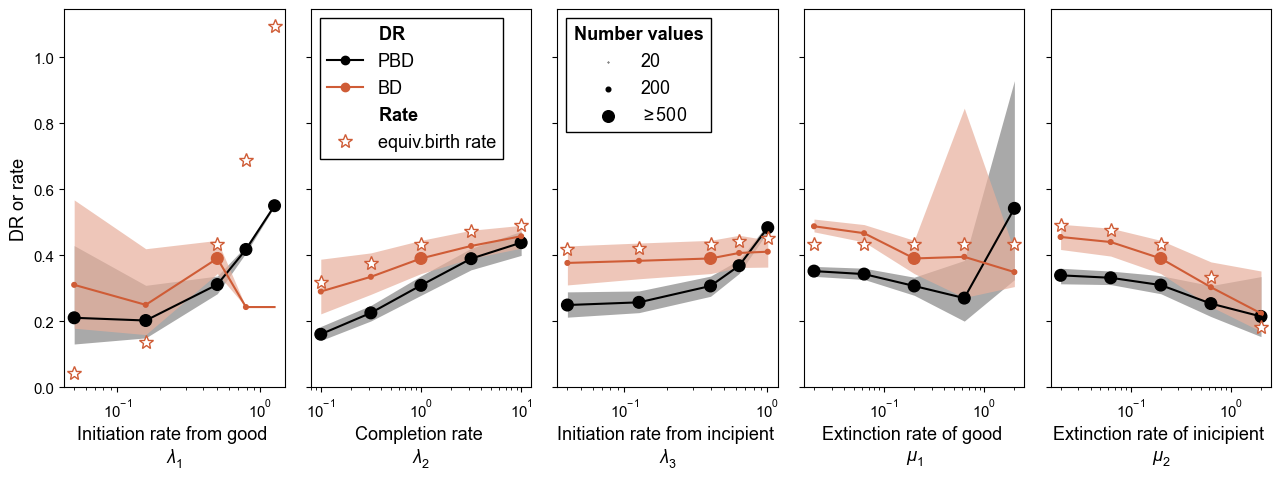

In [14]:
import matplotlib.patches


fig, axes = plt.subplots(1, 5, figsize = (13,5), sharey=True)

markersize = lambda n: 70*(np.clip(n,0,500) / 500)**2

ax_legend = 1
axes[ax_legend].add_patch(matplotlib.patches.Rectangle((0,0), 0, 0, color='w', label = "$\\mathbf{DR}$"))
for i_par in range(5):
    ax = axes[i_par]
    ax.set_xscale("log")
    #ax.set_yscale("log")

    # PBD
    ax.fill_between(par_vals[i_par, :, i_par], 
                    DR_med_quant_PBD[i_par, :, 1], DR_med_quant_PBD[i_par, :, 3], 
                    ec = '#858585', fc = '#858585', lw = 0, alpha = 0.7)
    

    # CBD
    ax.fill_between(par_vals[i_par, :, i_par], 
                    DR_med_quant_CBD[i_par, :, 1], DR_med_quant_CBD[i_par, :, 3], 
                    ec = '#e7af9c', fc = '#e7af9c', lw = 0, alpha = 0.7)
    #ax.plot(par_vals[i_par, :, i_par], DR_quantiles_CBD[i_par, :, 2], color = "#cf5c36", marker = "o", label = "BD") # 2 for median

    
    
    plot_scatter_size_label(ax, par_vals[i_par, :, i_par], DR_med_quant_PBD[i_par, :, 2], 
                            marker = "o", label = "PBD", size = markersize(n_trees_PBD[i_par, :]), 
                            color = "k", showLabel=(i_par == ax_legend))
    plot_scatter_size_label(ax, par_vals[i_par, :, i_par], DR_med_quant_CBD[i_par, :, 2], 
                            color = "#cf5c36", marker = "o", label = "BD", 
                            size = markersize(n_trees_CBD[i_par, :]), showLabel=(i_par == ax_legend))

    if i_par == ax_legend:
        label = "equiv.birth rate"
        ax.add_patch(matplotlib.patches.Rectangle((0,0), 0, 0, color='w', label = "$\\mathbf{Rate}$"))
    else:
        label = None
    ax.plot(par_vals[i_par, :, i_par], equiv_rates[i_par, :, 0], marker = "*", ls = "", label = label,
            markersize = 10, markeredgecolor = "#cf5c36", markerfacecolor = "w")

    
axes[0].set_ylim(0,axes[0].get_ylim()[1])
axes[0].set_ylabel("DR or rate")

legendstl = dict(loc = 2, title_fontproperties = dict(weight = 'bold'))

# Model legend
axes[ax_legend].legend(**legendstl)


# Markersize legend
ax = axes[2]
ax.scatter([],[], color = "k", marker = "o",s = markersize(20), label = str(20))
ax.scatter([],[], color = "k", marker = "o",s = markersize(200), label = str(200))
ax.scatter([],[], color = "k", marker = "o",s = markersize(500), label = "$\\geq 500$")
ax.legend(title = "Number values", **legendstl)
axes[0].set_xlabel("Initiation rate from good \n$\lambda_1$")
axes[1].set_xlabel("Completion rate \n$\lambda_2$")
axes[2].set_xlabel("Initiation rate from incipient \n$\lambda_3$")
axes[3].set_xlabel("Extinction rate of good \n$\mu_1$")
axes[4].set_xlabel("Extinction rate of inicipient \n$\mu_2$")
plt.savefig("../fig/SM_DR_by_method.pdf")
print("The shaded area corresponds to the first and third quartiles of the median DR on each tree.")